In [30]:
#Importing the all the libraries

import os
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Loading the Datasets form the directories

In [6]:
dataset_path = 'blur-dataset'

IN = '/media/revanth/Data/Hackathon/datahack/motion_blurred'
OUT = '/media/revanth/Data/Hackathon/datahack/sharp'

def data_load(path):
    result = []
    for file in tqdm(sorted(os.listdir(path))):
          if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
            image = tf.keras.preprocessing.image.load_img(path + '/' + file, target_size=(128,128))
            image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
            result.append(image)
    return np.array(result)

input_images = data_load(IN)
output_images = data_load(OUT)

100%|█████████████████████████████████████████| 350/350 [00:11<00:00, 29.25it/s]


Spliting the Data from Training set=80% and Testing set=20%

In [7]:
split_size=int(len(input_images)*0.8)

x_train=input_images[:split_size]
y_train=output_images[:split_size]

x_test=input_images[split_size:]
y_test=input_images[split_size:]

x_train.shape ,y_train.shape,x_test.shape,y_test.shape

((219, 128, 128, 3), (219, 128, 128, 3), (55, 128, 128, 3), (55, 128, 128, 3))

Displaying on Some Random Images from the Directores

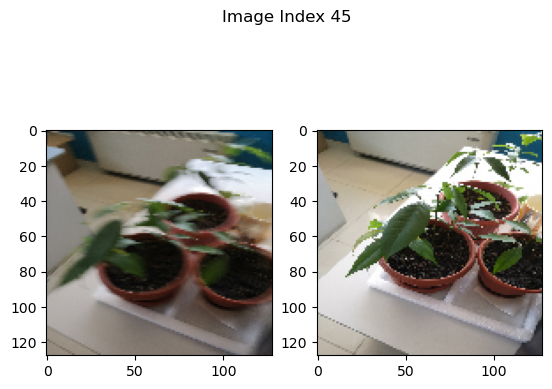

In [8]:
r=random.randint(0,len(input_images)-1)
fig=plt.figure()
plt.suptitle(f'Image Index {r}')
ax=fig.add_subplot(1,2,1)
ax.imshow(input_images[r])
ax=fig.add_subplot(1,2,2)
ax.imshow(output_images[r])

In [9]:
INPUT_SHAPE=(128,128,3)
BATCH_SIZE=32
KERNAL_SIZE=3
LATENT_DIM=256
layer_filters=[64,128,256]

Building on Encoder model for the Dataset

In [10]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder,self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=2,activation=tf.nn.relu,padding='same')
        self.conv2 = tf.keras.layers.Conv2D(filters=128,kernel_size=3,strides=2,activation=tf.nn.relu,padding='same')
        self.conv3 = tf.keras.layers.Conv2D(filters=256,kernel_size=3,strides=2,activation=tf.nn.relu,padding='same')
        self.flat = tf.keras.layers.Flatten()
        self.dns = tf.keras.layers.Dense(256,name='encoder_latent')
        
    def call(self,inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flat(x)
        x = self.dns(x)
        return x
    
    def build(self,shape=(128,128,3)):
        inputs = tf.keras.layers.Input(shape = shape, name = 'encoder_input')
        return tf.keras.Model(inputs,self.call(inputs),name='encoder')   

Displaying on summary of encoder model

In [11]:
encoder=Encoder()
encoder.build().summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 encoder_latent (Dense)      (None, 256)               16777472  
                                                                 
Total params: 17,148,288
Trainable params: 17,148,288
Non-t

2023-01-28 20:45:22.561387: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-28 20:45:22.561407: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-28 20:45:22.561427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kali): /proc/driver/nvidia/version does not exist
2023-01-28 20:45:22.561629: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder,self).__init__()
        self.dns = tf.keras.layers.Dense((16*16*256),name='decoder_latent')
        self.rshape = tf.keras.layers.Reshape((16,16,256))
        self.convt1 = tf.keras.layers.Conv2DTranspose(filters=256,kernel_size=3,strides=2,activation='relu',padding='same')
        self.convt2 = tf.keras.layers.Conv2DTranspose(filters=128,kernel_size=3,strides=2,activation='relu',padding='same')
        self.convt3 = tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=3,strides=2,activation='relu',padding='same')
        self.out = tf.keras.layers.Conv2DTranspose(filters=3,kernel_size=3,activation='sigmoid',padding='same',name='decoder_output')
        
    def call(self,inputs):
        x = self.dns(inputs)
        x = self.rshape(x)
        x = self.convt1(x)
        x = self.convt2(x)
        x = self.convt3(x)
        x = self.out(x)
        return x
    
    def build(self,shape=(256,)):
        inputs = tf.keras.layers.Input(shape = shape, name = 'decoder_input')
        return tf.keras.Model(inputs,self.call(inputs),name='decoder')

In [13]:
decoder=Decoder()
decoder.build().summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 decoder_latent (Dense)      (None, 65536)             16842752  
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 64)     7379

In [14]:
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self,inputs):
        inpt = inputs
        x = self.encoder(inpt)
        x = self.decoder(x)
        return x
        
    def build(self,shape=(128,128,3)):
        inputs = tf.keras.layers.Input(shape = shape, name = 'AutoEncoder_Input') 
        return tf.keras.Model(inputs, self.call(inputs) , name='AutoEncoder')        


In [15]:
autoencoder=AutoEncoder()
autoencoder.build().summary()

Model: "AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AutoEncoder_Input (InputLay  [(None, 128, 128, 3)]    0         
 er)                                                             
                                                                 
 encoder (Encoder)           (None, 256)               17148288  
                                                                 
 decoder (Decoder)           (None, 128, 128, 3)       17803395  
                                                                 
Total params: 34,951,683
Trainable params: 34,951,683
Non-trainable params: 0
_________________________________________________________________


In [16]:
autoencoder.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [17]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)
callbacks = [lr_reducer]

In [26]:
history = autoencoder.fit(input_images,
                      output_images,
                      validation_data=(input_images, output_images),
                      epochs=80,
                      batch_size=BATCH_SIZE,
                      callbacks=callbacks)

Epoch 1/80
9/9 [==============================] - 52s 6s/step - loss: 0.0067 - accuracy: 0.7539 - val_loss: 0.0063 - val_accuracy: 0.7460 - lr: 0.0010
Epoch 2/80
9/9 [==============================] - 50s 6s/step - loss: 0.0066 - accuracy: 0.7576 - val_loss: 0.0066 - val_accuracy: 0.7574 - lr: 0.0010
Epoch 3/80
9/9 [==============================] - 49s 6s/step - loss: 0.0065 - accuracy: 0.7589 - val_loss: 0.0062 - val_accuracy: 0.7586 - lr: 0.0010
Epoch 4/80
9/9 [==============================] - 49s 6s/step - loss: 0.0065 - accuracy: 0.7467 - val_loss: 0.0062 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 5/80
9/9 [==============================] - 49s 6s/step - loss: 0.0064 - accuracy: 0.7608 - val_loss: 0.0061 - val_accuracy: 0.7516 - lr: 0.0010
Epoch 6/80
9/9 [==============================] - 49s 6s/step - loss: 0.0061 - accuracy: 0.7617 - val_loss: 0.0058 - val_accuracy: 0.7579 - lr: 0.0010
Epoch 7/80
9/9 [==============================] - 50s 6s/step - loss: 0.0058 - accuracy: 0.759

Epoch 54/80
9/9 [==============================] - 44s 5s/step - loss: 0.0020 - accuracy: 0.8275 - val_loss: 0.0020 - val_accuracy: 0.8290 - lr: 3.1623e-04
Epoch 55/80
9/9 [==============================] - 43s 5s/step - loss: 0.0020 - accuracy: 0.8288 - val_loss: 0.0020 - val_accuracy: 0.8298 - lr: 3.1623e-04
Epoch 56/80
9/9 [==============================] - 44s 5s/step - loss: 0.0020 - accuracy: 0.8289 - val_loss: 0.0019 - val_accuracy: 0.8299 - lr: 3.1623e-04
Epoch 57/80
9/9 [==============================] - 44s 5s/step - loss: 0.0019 - accuracy: 0.8296 - val_loss: 0.0019 - val_accuracy: 0.8293 - lr: 3.1623e-04
Epoch 58/80
9/9 [==============================] - 44s 5s/step - loss: 0.0019 - accuracy: 0.8290 - val_loss: 0.0019 - val_accuracy: 0.8293 - lr: 3.1623e-04
Epoch 59/80
9/9 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.8293
Epoch 59: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
9/9 [==============================] - 45s 5s/ste

In [28]:
autoencoder.save('img_to_blur.tflite')

INFO:tensorflow:Assets written to: img_to_blur.tflite/assets


INFO:tensorflow:Assets written to: img_to_blur.tflite/assets



       Input                        Ground Truth                  Predicted Value
1/1 [==============================] - 0s 39ms/step


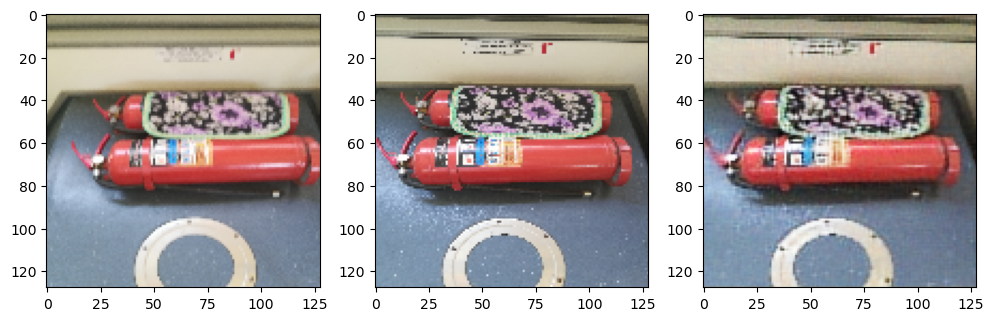

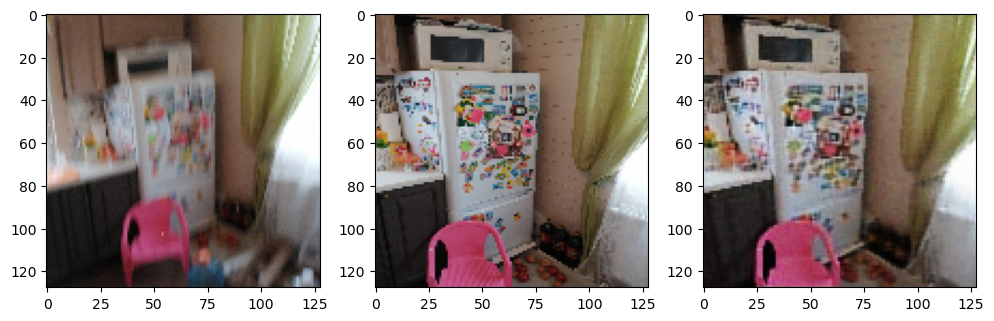

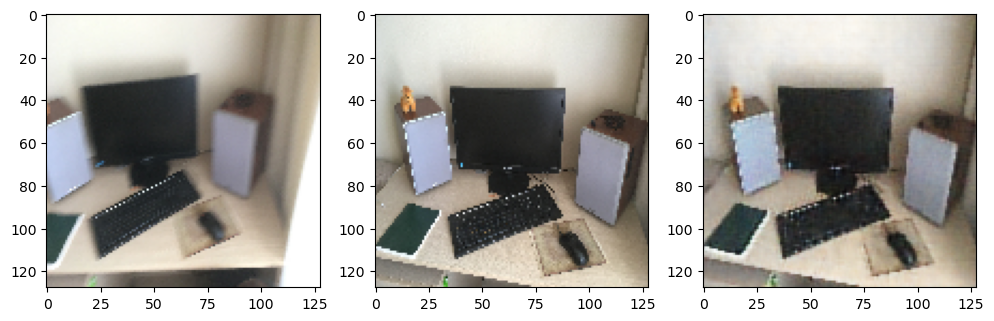

In [31]:
print("\n       Input                        Ground Truth                  Predicted Value")
for i in range(3):
    
    r = random.randint(0, len(output_images)-1)

    x, y = input_images[r],output_images[r]
    x_inp = x.reshape(1,128,128,3)
    result = autoencoder.predict(x_inp)
    result = result.reshape(128,128,3)

    fig = plt.figure(figsize=(12,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(result)